Import Library

In [40]:
import pandas as pd
from cleantext import clean
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import re
from collections import defaultdict
from transformers import EarlyStoppingCallback
import matplotlib
from spellchecker import SpellChecker
import emoji
import demoji
import contractions
import unicodedata
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
from scipy.special import softmax
import lxml
import numpy as np
import torch
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from torch.optim import AdamW
from transformers import RobertaTokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments, get_scheduler
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
import evaluate
from datasets import Dataset as HFDataset
from textattack.augmentation import WordNetAugmenter
from transformers import TrainerCallback
from tqdm import tqdm
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import RandomOverSampler
# Untuk interaktif terminal
import keyboard  # pip install keyboard
from transformers import pipeline
from deep_translator import GoogleTranslator

In [2]:
"""class:
0: hate speech
1: offensive language
2: neither
"""

'class:\n0: hate speech\n1: offensive language\n2: neither\n'

Import Dataset

In [3]:
df = pd.read_csv('data.csv')
df.drop(columns=[col for col in df.columns if col not in ['tweet', 'class']], inplace=True) #delete unimportant data
print(df['class'].value_counts())

class
1    19190
2     4163
0     1430
Name: count, dtype: int64


Preprocessing Data

In [4]:
# Load spaCy dan SpellChecker
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()
demoji.download_codes()

# Slang map manual (bisa ditambah)
SLANG_MAP = {
    "u": "you", "r": "are", "lol": "laughing out loud", "idk": "i do not know",
    "brb": "be right back", "gonna": "going to", "wanna": "want to",
    "lmao": "laughing my ass off", "omg": "oh my god", "smh": "shaking my head"
}

# Fungsi untuk ekspansi kontraksi dan slang
def expand_contractions_and_slang(text):
    text = contractions.fix(text)
    for slang, expanded in SLANG_MAP.items():
        text = re.sub(rf'\b{slang}\b', expanded, text)
    return text

# Fungsi untuk menghapus emoji dan emoticon
def remove_emoji_and_emoticon(text):
    text = emoji.replace_emoji(text, replace="")
    text = demoji.replace(text, "")
    return text

# Fungsi normalisasi unicode
def normalize_unicode(text):
    return unicodedata.normalize("NFC", text)

# Fungsi menghapus HTML tags
def remove_html(text):
    return BeautifulSoup(text, "lxml").get_text()

# Fungsi menghapus URL, email, telepon, dll
def clean_metadata(text):
    return clean(
        text,
        fix_unicode=True, to_ascii=True, lower=True,
        no_urls=True, no_emails=True, no_phone_numbers=True,
        no_numbers=False, no_digits=False, no_currency_symbols=False,
        no_line_breaks=True, no_punct=False
    )

# Fungsi untuk mengganti angka, tanggal, mata uang
def normalize_numbers_dates_currency(text):
    text = re.sub(r'\b\d{1,2}[/\-]\d{1,2}[/\-]?\d{2,4}\b', '<date>', text)  # tanggal
    text = re.sub(r'\$\d+(\.\d+)?', '<money>', text)                       # uang dolar
    text = re.sub(r'Rp ?[\d.]+', '<money>', text)                          # uang rupiah
    text = re.sub(r'\b\d+\b', '<num>', text)                               # angka
    return text

# Reduksi karakter berulang berlebihan
def reduce_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

# Hapus mention dan hashtag
def clean_social_patterns(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    return text

# Filter berdasarkan WordNet (meaningfulness check)
def wordnet_filter(tokens):
    return [token for token in tokens if wordnet.synsets(token)]

# Filter berdasarkan ejaan yang valid
def remove_gibberish_words(tokens):
    return [token for token in tokens if token in spell or len(token) <= 3]

# Filter Named Entities (opsional)
def remove_named_entities(tokens, raw_text):
    doc = nlp(raw_text)
    entities = {ent.text.lower() for ent in doc.ents}
    return [t for t in tokens if t not in entities]

# Fungsi utama cleaning
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    # Step 1: Normalisasi
    text = normalize_unicode(text)
    text = remove_html(text)
    text = clean_metadata(text)
    text = remove_emoji_and_emoticon(text)
    text = expand_contractions_and_slang(text)
    text = normalize_numbers_dates_currency(text)
    text = clean_social_patterns(text)
    text = reduce_repeated_characters(text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 2: Tokenisasi + Lemmatization
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_space and not token.is_punct:
            lemma = token.lemma_.lower()
            if lemma.isalpha():
                tokens.append(lemma)

    # Step 3: Filtering kata tidak valid
    tokens = remove_gibberish_words(tokens)
    tokens = wordnet_filter(tokens)
    tokens = remove_named_entities(tokens, text)

    return ' '.join(tokens)

# Persiapan DataFrame
df.dropna(subset=['tweet'], inplace=True)
df.drop_duplicates(subset=['tweet'], inplace=True)
df['tweet'] = df['tweet'].astype(str).apply(clean_text)


C:\Users\patri\AppData\Local\Temp\ipykernel_14872\1494959938.py:4: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [5]:
df.head() #for check the result

,class,tweet
0,2,woman complain clean house man trash
1,1,boy dat cold bad dat hoe place
2,1,fuck bitch start cry confuse shit
3,1,look like
4,1,shit hear true faker bitch tell


In [6]:
df.count() #check the data count

class    24783
tweet    24783
dtype: int64

Jumlah total dokumen: 24691
Rata-rata panjang teks (jumlah kata): 5.56


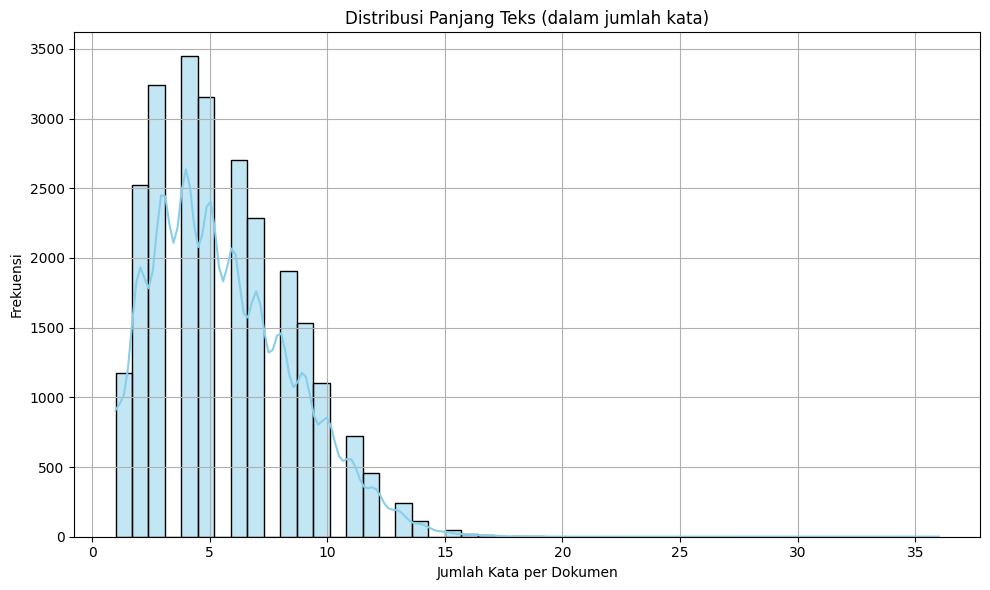

C:\Users\patri\AppData\Local\Temp\ipykernel_14872\2186243905.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='Set2')


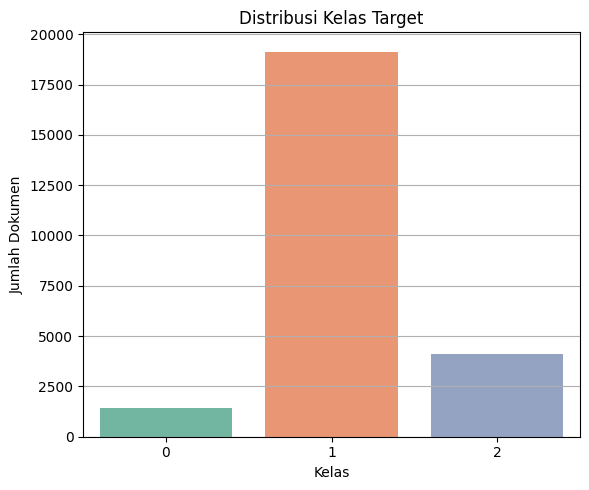


Distribusi kelas target:
class
0     1421
1    19136
2     4134
Name: count, dtype: int64

Rasio masing-masing kelas (persentase):
class
0     5.76
1    77.50
2    16.74
Name: count, dtype: float64


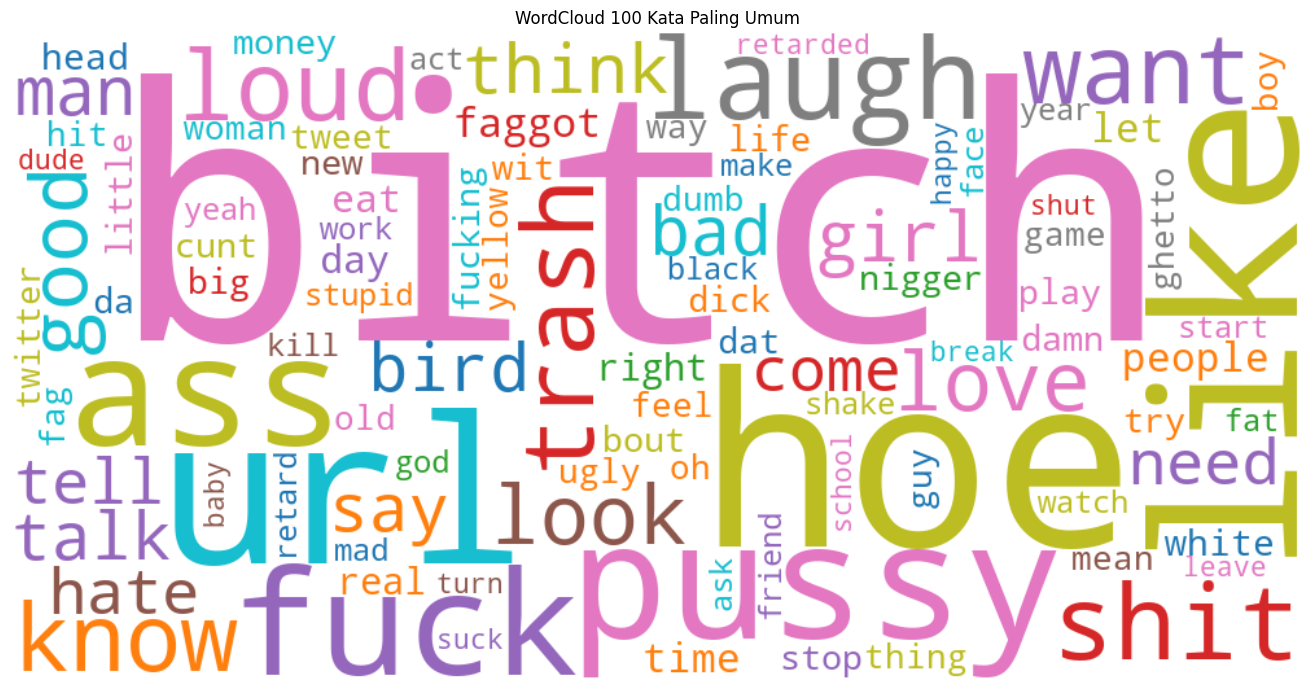


100 Kata Paling Umum dalam Dataset:
 1. bitch           : 11392
 2. hoe             : 4306
 3. url             : 3010
 4. like            : 2855
 5. pussy           : 2237
 6. ass             : 1978
 7. fuck            : 1943
 8. laugh           : 1554
 9. shit            : 1301
10. trash           : 1156
11. loud            : 1125
12. want            : 1093
13. know            : 1021
14. love            : 773
15. look            : 767
16. good            : 707
17. girl            : 696
18. think           : 671
19. man             : 637
20. bad             : 628
21. bird            : 599
22. talk            : 594
23. say             : 584
24. need            : 544
25. tell            : 535
26. hate            : 533
27. come            : 519
28. faggot          : 518
29. time            : 491
30. let             : 486
31. people          : 485
32. day             : 449
33. eat             : 441
34. real            : 423
35. right           : 419
36. head            : 399
37. white    

In [7]:
# Check if 'tweet' and 'class' columns exist
assert 'tweet' in df.columns, "Column 'tweet' not found in dataset."
assert df['tweet'].notnull().all(), "There is a null value in the 'tweet' column."

# Hapus baris kosong atau hanya whitespace
df = df[df['tweet'].str.strip().astype(bool)]

# Jumlah total dokumen
total_documents = df.shape[0]
print(f"Jumlah total dokumen: {total_documents}")

# Hitung panjang teks (jumlah kata per dokumen)
df['jumlah_kata'] = df['tweet'].apply(lambda x: len(x.split()))

# Rata-rata panjang teks
rata_rata_kata = df['jumlah_kata'].mean()
print(f"Rata-rata panjang teks (jumlah kata): {rata_rata_kata:.2f}")

# Visualisasi Distribusi Panjang Teks
plt.figure(figsize=(10, 6))
sns.histplot(df['jumlah_kata'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks (dalam jumlah kata)')
plt.xlabel('Jumlah Kata per Dokumen')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribusi kelas target
target_col = 'class' if 'class' in df.columns else None
if target_col:
    plt.figure(figsize=(6, 5))
    sns.countplot(x=target_col, data=df, palette='Set2')
    plt.title('Distribusi Kelas Target')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Dokumen')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    kelas_counts = df[target_col].value_counts().sort_index()
    print("\nDistribusi kelas target:")
    print(kelas_counts)

    print("\nRasio masing-masing kelas (persentase):")
    print((kelas_counts / kelas_counts.sum() * 100).round(2))
else:
    print("Kolom 'class' tidak ditemukan dalam dataset.")

# Kata-kata paling umum dengan CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(df['tweet'])
word_counts = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
freq_dict = dict(zip(vocab, word_counts))

# WordCloud visualisasi
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='tab10',
    max_words=100
)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud 100 Kata Paling Umum')
plt.tight_layout()
plt.show()

# 100 kata paling umum secara numerik
sorted_freq = sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)

# Hitung kata per kelas (hanya untuk 100 kata teratas)
print("\n100 Kata Paling Umum dalam Dataset:")
for i, (word, freq) in enumerate(sorted_freq[:100], 1):
    print(f"{i:>2}. {word:<15} : {freq}")

Cleaning Text Manual

In [8]:
stop_context_words = {
    "like", "know", "want", "need", "let", "time", "life", "day", "real",
    "right", "way", "thing", "work", "start", "ask", "turn", "leave",
    "new", "make", "try", "come", "watch", "break", "tell", "say", "feel",
    "url", "tweet", "twitter", "baby", "yeah", "friend", "school"
}


def bersihkan_teks(teks):
    kata = teks.lower().split()
    kata_bersih = [w for w in kata if w not in stop_context_words]
    return ' '.join(kata_bersih)

df['tweet'] = df['tweet'].apply(bersihkan_teks)
df.drop(columns=['jumlah_kata'], inplace=True)
df.head()

,class,tweet
0,2,woman complain clean house man trash
1,1,boy dat cold bad dat hoe place
2,1,fuck bitch cry confuse shit
3,1,look
4,1,shit hear true faker bitch


Set Seed for Reproducibility

In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Stratified Split

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

Minor Class Augmentation

In [ ]:
import nltk

# Wajib download dulu
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load model embedding sekali
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def eda_synonym_replace(text, n=1):
    words = text.split()
    if len(words) < 1:
        return text
    new_words = words.copy()
    for _ in range(n):
        idx = random.randrange(len(words))
        syns = wordnet.synsets(words[idx])
        if syns:
            lemmas = syns[0].lemmas()
            if lemmas:
                new = lemmas[0].name().replace('_', ' ')
                if new != words[idx]:
                    new_words[idx] = new
    return ' '.join(new_words)

def is_semantic_similar(orig, aug, threshold=0.8):
    v1, v2 = embed_model.encode([orig, aug], convert_to_tensor=False)
    cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return cos >= threshold

def augment_class(texts, target_n, max_trials=10):
    augmented = list(texts)
    trials = 0
    while len(augmented) < target_n and trials < max_trials * len(texts):
        t = random.choice(texts)
        ed = eda_synonym_replace(t, n=2)
        if is_semantic_similar(t, ed):
            augmented.append(ed)
        trials += 1
    # Fallback jika gagal augmentasi
    while len(augmented) < target_n:
        augmented.append(random.choice(texts))
    return augmented[:target_n]

def oversample_minority_only(df, label_col='class', text_col='tweet'):
    label_counts = df[label_col].value_counts()
    max_count = label_counts.max()
    balanced_dfs = []

    for label in label_counts.index:
        df_label = df[df[label_col] == label]
        count = len(df_label)

        if count < max_count:
            texts = df_label[text_col].tolist()
            augmented_texts = augment_class(texts, target_n=max_count)
            df_augmented = pd.DataFrame({
                text_col: augmented_texts,
                label_col: [label] * max_count
            })
            balanced_dfs.append(df_augmented)
        else:
            balanced_dfs.append(df_label)

    return pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Gunakan
train_df = oversample_minority_only(train_df, label_col='class', text_col='tweet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Tokenize Roberta

In [16]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Custom Dataset

In [17]:
MAX_LEN = 48

class TweetDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = str(self.data.iloc[index]['tweet'])
        label = int(self.data.iloc[index]['class'])
        encoding = self.tokenizer(tweet, max_length=self.max_length, padding='max_length',
                                    truncation=True, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = TweetDataset(train_df, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_df, tokenizer, MAX_LEN)


Class Weights for Imbalance class

In [18]:
labels = train_df['class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Model DeBERTa v3 Large

In [19]:
model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-large", num_labels=3)
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)
model.to("cuda")

e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

Loss Function Custom via Trainer

In [20]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

matrix evaluation

In [21]:
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    macro_f1 = metric_f1.compute(predictions=preds, references=labels, average="macro")['f1']
    macro_precision = metric_precision.compute(predictions=preds, references=labels, average="macro")['precision']
    macro_recall = metric_recall.compute(predictions=preds, references=labels, average="macro")['recall']
    return {
        'f1_macro': macro_f1,
        'precision_macro': macro_precision,
        'recall_macro': macro_recall
    }

TrainingArguments

In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    max_grad_norm=1.0
)

Trainer Init

In [23]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Training

In [25]:
trainer.train()

  0%|          | 0/45928 [00:00<?, ?it/s]

{'loss': 1.0796, 'grad_norm': 12.673376083374023, 'learning_rate': 6.531678641410842e-08, 'epoch': 0.0}
{'loss': 1.1105, 'grad_norm': 10.03668212890625, 'learning_rate': 1.3063357282821684e-07, 'epoch': 0.0}
{'loss': 1.0995, 'grad_norm': 10.358956336975098, 'learning_rate': 1.9595035924232528e-07, 'epoch': 0.01}
{'loss': 1.0935, 'grad_norm': 8.966464042663574, 'learning_rate': 2.612671456564337e-07, 'epoch': 0.01}
{'loss': 1.1027, 'grad_norm': 8.028986930847168, 'learning_rate': 3.2658393207054215e-07, 'epoch': 0.01}
{'loss': 1.1143, 'grad_norm': 9.095061302185059, 'learning_rate': 3.9190071848465057e-07, 'epoch': 0.01}
{'loss': 1.102, 'grad_norm': 8.288304328918457, 'learning_rate': 4.5721750489875904e-07, 'epoch': 0.01}
{'loss': 1.1353, 'grad_norm': nan, 'learning_rate': 5.160026126714566e-07, 'epoch': 0.01}
{'loss': 1.1024, 'grad_norm': 8.530811309814453, 'learning_rate': 5.813193990855651e-07, 'epoch': 0.02}
{'loss': 1.0962, 'grad_norm': 9.49052906036377, 'learning_rate': 6.4010450

  0%|          | 0/618 [00:00<?, ?it/s]

{'eval_loss': 0.6482363343238831, 'eval_f1_macro': 0.6911174777853312, 'eval_precision_macro': 0.6544939979034426, 'eval_recall_macro': 0.7527467721228795, 'eval_runtime': 70.5003, 'eval_samples_per_second': 70.056, 'eval_steps_per_second': 8.766, 'epoch': 1.0}


e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.5282, 'grad_norm': 32.47459411621094, 'learning_rate': 2.916535623563566e-05, 'epoch': 1.0}
{'loss': 0.5402, 'grad_norm': 87.63432312011719, 'learning_rate': 2.9158098463771622e-05, 'epoch': 1.0}
{'loss': 0.5623, 'grad_norm': 75.93299865722656, 'learning_rate': 2.9150840691907586e-05, 'epoch': 1.01}
{'loss': 0.6236, 'grad_norm': 4.147706985473633, 'learning_rate': 2.9143582920043546e-05, 'epoch': 1.01}
{'loss': 0.5501, 'grad_norm': 4.472803115844727, 'learning_rate': 2.913632514817951e-05, 'epoch': 1.01}
{'loss': 0.4128, 'grad_norm': 1.5951613187789917, 'learning_rate': 2.912906737631547e-05, 'epoch': 1.01}
{'loss': 0.4185, 'grad_norm': 2.6143393516540527, 'learning_rate': 2.9121809604451433e-05, 'epoch': 1.01}
{'loss': 0.4822, 'grad_norm': 1.7617828845977783, 'learning_rate': 2.9114551832587397e-05, 'epoch': 1.01}
{'loss': 0.3242, 'grad_norm': 1.141045331954956, 'learning_rate': 2.9107294060723357e-05, 'epoch': 1.02}
{'loss': 0.4479, 'grad_norm': 1.4659048318862915, 'learni

  0%|          | 0/618 [00:00<?, ?it/s]

{'eval_loss': 0.699578583240509, 'eval_f1_macro': 0.6952173216381087, 'eval_precision_macro': 0.6626034766499388, 'eval_recall_macro': 0.764545598871615, 'eval_runtime': 69.3143, 'eval_samples_per_second': 71.255, 'eval_steps_per_second': 8.916, 'epoch': 2.0}


e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.5109, 'grad_norm': 2.2607791423797607, 'learning_rate': 2.5000846740050804e-05, 'epoch': 2.0}
{'loss': 0.6854, 'grad_norm': 1.970394492149353, 'learning_rate': 2.4993588968186768e-05, 'epoch': 2.0}
{'loss': 0.5174, 'grad_norm': 1.1221781969070435, 'learning_rate': 2.498633119632273e-05, 'epoch': 2.0}
{'loss': 0.3095, 'grad_norm': 3.7629661560058594, 'learning_rate': 2.497907342445869e-05, 'epoch': 2.01}
{'loss': 0.2962, 'grad_norm': 10.936631202697754, 'learning_rate': 2.4971815652594655e-05, 'epoch': 2.01}
{'loss': 0.4898, 'grad_norm': 1.6627521514892578, 'learning_rate': 2.496455788073062e-05, 'epoch': 2.01}
{'loss': 0.4741, 'grad_norm': 1.6728465557098389, 'learning_rate': 2.495730010886658e-05, 'epoch': 2.01}
{'loss': 0.7837, 'grad_norm': 57.236690521240234, 'learning_rate': 2.4950042337002543e-05, 'epoch': 2.01}
{'loss': 0.2951, 'grad_norm': 1.0969974994659424, 'learning_rate': 2.4942784565138506e-05, 'epoch': 2.02}
{'loss': 0.4684, 'grad_norm': 9.507614135742188, 'lear

  0%|          | 0/618 [00:00<?, ?it/s]

{'eval_loss': 0.9187488555908203, 'eval_f1_macro': 0.5608126756620168, 'eval_precision_macro': 0.5619558421758484, 'eval_recall_macro': 0.7035042210834277, 'eval_runtime': 72.009, 'eval_samples_per_second': 68.589, 'eval_steps_per_second': 8.582, 'epoch': 3.0}


e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.8234, 'grad_norm': 3.9987168312072754, 'learning_rate': 2.0837788798838757e-05, 'epoch': 3.0}
{'loss': 0.7457, 'grad_norm': 2.1927952766418457, 'learning_rate': 2.083053102697472e-05, 'epoch': 3.0}
{'loss': 0.5224, 'grad_norm': 16.98040199279785, 'learning_rate': 2.082327325511068e-05, 'epoch': 3.0}
{'loss': 0.6894, 'grad_norm': 5.836237907409668, 'learning_rate': 2.0816015483246645e-05, 'epoch': 3.01}
{'loss': 0.7256, 'grad_norm': 1.3064402341842651, 'learning_rate': 2.0808757711382605e-05, 'epoch': 3.01}
{'loss': 0.5949, 'grad_norm': 2.579000234603882, 'learning_rate': 2.080149993951857e-05, 'epoch': 3.01}
{'loss': 0.6156, 'grad_norm': 2.175907850265503, 'learning_rate': 2.0794242167654532e-05, 'epoch': 3.01}
{'loss': 0.5525, 'grad_norm': 2.571282148361206, 'learning_rate': 2.0786984395790492e-05, 'epoch': 3.01}
{'loss': 0.6837, 'grad_norm': 2.7894489765167236, 'learning_rate': 2.0779726623926456e-05, 'epoch': 3.02}
{'loss': 0.6656, 'grad_norm': 1.1034010648727417, 'learni

  0%|          | 0/618 [00:00<?, ?it/s]

{'eval_loss': 0.8697715401649475, 'eval_f1_macro': 0.42469122527935066, 'eval_precision_macro': 0.6005079858884789, 'eval_recall_macro': 0.625099529734591, 'eval_runtime': 73.2234, 'eval_samples_per_second': 67.451, 'eval_steps_per_second': 8.44, 'epoch': 4.0}


e:\Users\Patrick\anaconda3\envs\pt-gpu\Lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


{'loss': 0.717, 'grad_norm': 5.210709571838379, 'learning_rate': 1.66732793032539e-05, 'epoch': 4.0}
{'loss': 0.4514, 'grad_norm': 1.3021820783615112, 'learning_rate': 1.6666021531389863e-05, 'epoch': 4.0}
{'loss': 0.6859, 'grad_norm': 3.7479422092437744, 'learning_rate': 1.6658763759525824e-05, 'epoch': 4.0}
{'loss': 0.6328, 'grad_norm': 68.73187255859375, 'learning_rate': 1.6651505987661787e-05, 'epoch': 4.01}
{'loss': 0.4314, 'grad_norm': 5.084486484527588, 'learning_rate': 1.664424821579775e-05, 'epoch': 4.01}
{'loss': 0.7141, 'grad_norm': 1.232517123222351, 'learning_rate': 1.663699044393371e-05, 'epoch': 4.01}
{'loss': 0.4665, 'grad_norm': 3.080862522125244, 'learning_rate': 1.6629732672069675e-05, 'epoch': 4.01}
{'loss': 0.596, 'grad_norm': 2.2117819786071777, 'learning_rate': 1.6622474900205638e-05, 'epoch': 4.01}
{'loss': 0.3875, 'grad_norm': 1.791967749595642, 'learning_rate': 1.6615217128341598e-05, 'epoch': 4.01}
{'loss': 0.4581, 'grad_norm': 2.235466241836548, 'learning_ra

  0%|          | 0/618 [00:00<?, ?it/s]

{'eval_loss': 1.0649962425231934, 'eval_f1_macro': 0.23495703983475344, 'eval_precision_macro': 0.3898887644034938, 'eval_recall_macro': 0.3860291309749347, 'eval_runtime': 69.5543, 'eval_samples_per_second': 71.009, 'eval_steps_per_second': 8.885, 'epoch': 5.0}
{'train_runtime': 45292.4422, 'train_samples_per_second': 8.112, 'train_steps_per_second': 1.014, 'train_loss': 0.592389547739725, 'epoch': 5.0}


TrainOutput(global_step=28705, training_loss=0.592389547739725, metrics={'train_runtime': 45292.4422, 'train_samples_per_second': 8.112, 'train_steps_per_second': 1.014, 'total_flos': 2.006247214175501e+16, 'train_loss': 0.592389547739725, 'epoch': 5.0})

Final Evaluation

In [26]:
preds_output = trainer.predict(test_dataset)
probs = softmax(preds_output.predictions, axis=1)
preds = np.argmax(probs, axis=1)
true_labels = test_df['class'].values
print("Shape of probs:", probs.shape)
print("Shape of true_labels:", true_labels.shape)
print("Unique true labels:", np.unique(true_labels))


print("\nClassification Report:")
print(classification_report(true_labels, preds))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, preds))

roc_auc = roc_auc_score(true_labels, probs, average='weighted', multi_class='ovo')
print(f"\nROC AUC Macro: {roc_auc:.4f}")

f1_macro = f1_score(true_labels, preds, average='weighted')
print(f"Macro F1 Score: {f1_macro:.4f}")

  0%|          | 0/618 [00:00<?, ?it/s]

Shape of probs: (4939, 3)
Shape of true_labels: (4939,)
Unique true labels: [0 1 2]

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.56      0.37       284
           1       0.97      0.86      0.91      3828
           2       0.74      0.88      0.81       827

    accuracy                           0.84      4939
   macro avg       0.66      0.76      0.70      4939
weighted avg       0.89      0.84      0.86      4939


Confusion Matrix:
[[ 158   95   31]
 [ 330 3276  222]
 [  77   21  729]]

ROC AUC Macro: 0.8662
Macro F1 Score: 0.8597


fungsi agar bs jlnnin program input dn output pggna ktk vscode close

In [35]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Path absolut untuk Windows
model_path = r"D:\Patrick\Sekolah\Semester 6\PENGOLAHAN BAHASA ALAMI\Tubes_new\saved_hate_speech_model"
tokenizer_path = r"D:\Patrick\Sekolah\Semester 6\PENGOLAHAN BAHASA ALAMI\Tubes_new\saved_tokenizer"

# Simpan model & tokenizer
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)


('D:\\Patrick\\Sekolah\\Semester 6\\PENGOLAHAN BAHASA ALAMI\\Tubes_new\\saved_tokenizer\\tokenizer_config.json',
 'D:\\Patrick\\Sekolah\\Semester 6\\PENGOLAHAN BAHASA ALAMI\\Tubes_new\\saved_tokenizer\\special_tokens_map.json',
 'D:\\Patrick\\Sekolah\\Semester 6\\PENGOLAHAN BAHASA ALAMI\\Tubes_new\\saved_tokenizer\\vocab.json',
 'D:\\Patrick\\Sekolah\\Semester 6\\PENGOLAHAN BAHASA ALAMI\\Tubes_new\\saved_tokenizer\\merges.txt',
 'D:\\Patrick\\Sekolah\\Semester 6\\PENGOLAHAN BAHASA ALAMI\\Tubes_new\\saved_tokenizer\\added_tokens.json')

kalau mau makai ulang langsung run ini kalau udah ketutup kodenyaa dari vscode

In [ ]:
# Path sama seperti saat disimpan
model_path = r"D:\Patrick\Sekolah\Semester 6\PENGOLAHAN BAHASA ALAMI\Tubes_new\saved_hate_speech_model"
tokenizer_path = r"D:\Patrick\Sekolah\Semester 6\PENGOLAHAN BAHASA ALAMI\Tubes_new\saved_tokenizer"

# Load model & tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Pindahkan ke GPU jika ada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

program input dan output pengguna

In [41]:
def interactive_mode(model, tokenizer):
    print("\n✅ Selamat datang di program deteksi kata kata")
    print("Silahkan pilih menu dibawah ini dengan input angka yang tersedia:")
    print("1. Deteksi kata kata")
    print("2. Keluar dari program")

    while True:
        pilihan = input("\nMasukkan pilihan Anda (1 atau 2): ")
        if pilihan == '2':
            print("👋 Terima kasih, program selesai.")
            break
        elif pilihan == '1':
            translator = Translator()
            print("\n[ Mode Deteksi Aktif ] Tekan ESC kapan saja untuk keluar.")

            while True:
                print("\n1. Masukkan kata kata untuk mendeteksi:")
                print("2. Klik ESC untuk keluar dari program")

                if keyboard.is_pressed('esc'):
                    print("👋 Program keluar dari mode deteksi.")
                    return

                user_input = input("\nMasukkan teks: ")
                if user_input.strip() == "":
                    print("⚠️ Input tidak boleh kosong!")
                    continue

                try:
                    # Translate input to English
                    translated = GoogleTranslator(source='auto', target='en').translate(user_input)
                    print(f"📘 Teks hasil translate (English): {translated}")

                    # Tokenisasi dan inferensi
                    inputs = tokenizer(translated, return_tensors="pt", max_length=48,
                                        truncation=True, padding='max_length')
                    inputs = {k: v.to(model.device) for k, v in inputs.items()}
                    outputs = model(**inputs)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                    pred_class = torch.argmax(probs, dim=-1).item()

                    label_map = {
                        0: "❌ Hate Speech",
                        1: "⚠️ Offensive Language",
                        2: "✅ Netral"
                    }
                    print(f"\n🔍 Hasil Deteksi: {label_map[pred_class]} (Confidence: {probs[0][pred_class]:.4f})")

                except Exception as e:
                    print(f"❗ Terjadi kesalahan: {e}")
        else:
            print("⚠️ Pilihan tidak valid. Harap input 1 atau 2.")
# Jalankan program interaktif deteksi kata
interactive_mode(model, tokenizer)


✅ Selamat datang di program deteksi kata kata
Silahkan pilih menu dibawah ini dengan input angka yang tersedia:
1. Deteksi kata kata
2. Keluar dari program

[ Mode Deteksi Aktif ] Tekan ESC kapan saja untuk keluar.

1. Masukkan kata kata untuk mendeteksi:
2. Klik ESC untuk keluar dari program
📘 Teks hasil translate (English): lol

🔍 Hasil Deteksi: ✅ Netral (Confidence: 0.9920)

1. Masukkan kata kata untuk mendeteksi:
2. Klik ESC untuk keluar dari program
📘 Teks hasil translate (English): i hate you

🔍 Hasil Deteksi: ❌ Hate Speech (Confidence: 0.9152)

1. Masukkan kata kata untuk mendeteksi:
2. Klik ESC untuk keluar dari program
📘 Teks hasil translate (English): fuck you bitch

🔍 Hasil Deteksi: ⚠️ Offensive Language (Confidence: 0.8152)

1. Masukkan kata kata untuk mendeteksi:
2. Klik ESC untuk keluar dari program
📘 Teks hasil translate (English): you are so stupid

🔍 Hasil Deteksi: ✅ Netral (Confidence: 0.9817)

1. Masukkan kata kata untuk mendeteksi:
2. Klik ESC untuk keluar dari pro

load ulg klo vscode kttp

In [ ]:
interactive_mode(model, tokenizer)